In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import json

pd.set_option('display.max_rows', None)  

# set up paths, variables, and initial dataframe
ABCD_base_dir = '/u/home/n/npeterse/BPM/abcd-data-release-5.1/'
file_path = f'{ABCD_base_dir}core/physical-health/ph_y_sal_horm.csv'
pds_data_path = '/u/home/n/npeterse/BPM/abcd-data-release-5.1/core/physical-health/ph_y_pds.csv'
df = pd.read_csv(file_path, low_memory=False)

# Filter for year 4 data
df_year4 = df[df['eventname'] == "4_year_follow_up_y_arm_1"].copy()

# Define hormone columns and their thresholds
hormones = {
    'hormone_scr_dhea': (5, 1000),
    'hormone_scr_ert': (5, 500),   
    'hormone_scr_hse': (0, 1500)
}

brain_measurements = {
    'area': '/u/home/n/npeterse/y4_only_mri_y_smr_area_dsk.csv',
    'thickness': '/u/home/n/npeterse/y4_only_mri_y_smr_thk_dsk.csv',
    'volume': '/u/home/n/npeterse/y4_only_mri_y_smr_vol_dsk.csv'
}

# force hormone values to numeric
for hormone in hormones.keys():
    df_year4[f'{hormone}_rep1'] = pd.to_numeric(df_year4[f'{hormone}_rep1'], errors='coerce')
    df_year4[f'{hormone}_rep2'] = pd.to_numeric(df_year4[f'{hormone}_rep2'], errors='coerce')

# set up loop to loop through hormones 
def clean_hormone_data(df, hormone_name, lower_bound, upper_bound):
    rep1 = f'{hormone_name}_rep1'
    rep2 = f'{hormone_name}_rep2'

    # Set outliers to NaN
    df.loc[(df[rep1] < lower_bound) | (df[rep1] > upper_bound), rep1] = np.nan
    df.loc[(df[rep2] < lower_bound) | (df[rep2] > upper_bound), rep2] = np.nan
    
    # Average the two replicates
    df[f'filtered_{hormone_name}'] = df[[rep1, rep2]].mean(axis=1)

# run for all hormones
for hormone, (lower, upper) in hormones.items():
    clean_hormone_data(df_year4, hormone, lower, upper)



In [2]:
# Load the cleaned hormone data
cleaned_hormone_data_path = ABCD_base_dir + 'cleaned_hormone_data.csv'
cleaned_hormone_df = pd.read_csv(cleaned_hormone_data_path)

# Load the included participants
included_participants_path = '/u/home/n/npeterse/oc_work/included_participants.csv'
included_participants_df = pd.read_csv(included_participants_path)

# Print the number of unique participants before filtering
print("Number of unique participants before filtering:", cleaned_hormone_df['src_subject_id'].nunique())

# Filter the cleaned hormone data to only include participants in the included participants list
filtered_df = cleaned_hormone_df[cleaned_hormone_df['src_subject_id'].isin(included_participants_df['src_subject_id'])]

# Print the number of unique participants after filtering
print("Number of unique participants after filtering:", filtered_df['src_subject_id'].nunique())

# Optionally, save the filtered data to a new CSV
#filtered_df.to_csv('filtered_cleaned_hormone_data.csv', index=False)


Number of unique participants before filtering: 1149
Number of unique participants after filtering: 860


In [3]:
# correlate hormones with brain measurements separately for ocp+ and ocp-

def compute_spearman_correlations(cleaned_hormone_df, brain_measurement_files, ocp_file_path):
    ocp_df = pd.read_csv(ocp_file_path)
    ocp_df_4y = ocp_df[ocp_df['eventname'] == '4_year_follow_up_y_arm_1']

    correlation_results = {'OCP_0': {}, 'OCP_1': {}}

    # Loop through each type of brain measurement (area, thickness, volume)
    for measurement_type, brain_file_path in brain_measurement_files.items():
        brain_df = pd.read_csv(brain_file_path)
        
        # Drop 'eventname' column if present
        brain_df = brain_df.drop(columns=['eventname'], errors='ignore')

        # Merge hormone, brain, and OCP data on 'src_subject_id'
        merged_df = pd.merge(cleaned_hormone_df, brain_df, on='src_subject_id', how='inner')
        merged_df = pd.merge(merged_df, ocp_df_4y[['src_subject_id', 'menstrualcycle4_y']], on='src_subject_id', how='inner')

        hormone_columns = [col for col in merged_df.columns if col.startswith('filtered_hormone_scr')]
        brain_columns = [col for col in brain_df.columns if col != 'src_subject_id']

        # Loop over each hormone and brain measurement
        for hormone in hormone_columns:
            for brain_measure in brain_columns:
                for ocp_group in [0, 1]:
                    group_data = merged_df[merged_df['menstrualcycle4_y'] == ocp_group]
                    valid_data = group_data[[hormone, brain_measure]].dropna()

                    if not valid_data.empty:
                        rho, p_value = spearmanr(valid_data[hormone], valid_data[brain_measure])
                        sample_size = len(valid_data)

                        # Store results, now including the brain measurement type
                        correlation_results[f'OCP_{ocp_group}'][f'{hormone}_vs_{brain_measure}_{measurement_type}'] = {
                            'rho': rho, 'p_value': p_value, 'sample_size': sample_size
                        }

    return correlation_results

# Example usage for all brain measurement types
correlations_all_measurements = compute_spearman_correlations(filtered_df, brain_measurements, pds_data_path)



{
    "OCP_0": {
        "filtered_hormone_scr_dhea_vs_smri_area_cdk_banksstslh_area": {
            "rho": -0.06551029968730927,
            "p_value": 0.06141589234602309,
            "sample_size": 816
        },
        "filtered_hormone_scr_dhea_vs_smri_area_cdk_cdacatelh_area": {
            "rho": -0.012092513006261593,
            "p_value": 0.7301587629392874,
            "sample_size": 816
        },
        "filtered_hormone_scr_dhea_vs_smri_area_cdk_cdmdfrlh_area": {
            "rho": -0.0018354968440317174,
            "p_value": 0.9582482633109108,
            "sample_size": 816
        },
        "filtered_hormone_scr_dhea_vs_smri_area_cdk_cuneuslh_area": {
            "rho": 0.011670521952534601,
            "p_value": 0.7392270732443549,
            "sample_size": 816
        },
        "filtered_hormone_scr_dhea_vs_smri_area_cdk_ehinallh_area": {
            "rho": -0.04374071682228182,
            "p_value": 0.21196997454733285,
            "sample_size": 816
      

In [4]:
# Load the participants that were included in the MRI analyses after cleaning
included_participants = pd.read_csv('/u/home/n/npeterse/oc_work/included_participants.csv')

# Load menstrual cycle data (OCP use)
menstrual_data = pd.read_csv('/u/home/n/npeterse/BPM/abcd-data-release-5.1/core/physical-health/ph_y_pds.csv')

# Filter df_year4 to only include participants present in the 'included_participants' file
included_subjects = included_participants['src_subject_id'].unique()
df_year4 = df_year4[df_year4['src_subject_id'].isin(included_subjects)]

# Merge df_year4 with menstrual data and filter for valid menstrual cycle values (0, 1)
merged_df = pd.merge(df_year4, menstrual_data[['src_subject_id', 'menstrualcycle4_y']], on='src_subject_id')
filtered_df = merged_df[merged_df['menstrualcycle4_y'].isin([0, 1])]

# List of hormones to analyze
hormones = ['filtered_hormone_scr_dhea', 'filtered_hormone_scr_ert', 'filtered_hormone_scr_hse']

# Function to compare hormone levels between groups
def compare_hormone_levels(df, hormone):
    group_0 = df[df['menstrualcycle4_y'] == 0][hormone].dropna()
    group_1 = df[df['menstrualcycle4_y'] == 1][hormone].dropna()
    
    # Perform a t-test
    t_stat, p_val = stats.ttest_ind(group_0, group_1)
    
    print(f"Hormone: {hormone}")
    print(f"Mean for group 0: {group_0.mean()}, Mean for group 1: {group_1.mean()}")
    print(f"Group 0 (Menstrual Cycle 0) - Count: {len(group_0)}, Mean: {group_0.mean()}")
    print(f"Group 1 (Menstrual Cycle 1) - Count: {len(group_1)}, Mean: {group_1.mean()}")
    print(f"T-statistic: {t_stat}, P-value: {p_val}")
    print("\n")

# Run the hormone comparison for each hormone
for hormone in hormones:
    compare_hormone_levels(filtered_df, hormone)

#print(merged_df)

Hormone: filtered_hormone_scr_dhea
Mean for group 0: 193.2384801522567, Mean for group 1: 145.33167741935486
Group 0 (Menstrual Cycle 0) - Count: 1839, Mean: 193.2384801522567
Group 1 (Menstrual Cycle 1) - Count: 62, Mean: 145.33167741935486
T-statistic: 3.024307275954448, P-value: 0.002525430517511333


Hormone: filtered_hormone_scr_ert
Mean for group 0: 64.93971374663073, Mean for group 1: 47.11620161290321
Group 0 (Menstrual Cycle 0) - Count: 1855, Mean: 64.93971374663073
Group 1 (Menstrual Cycle 1) - Count: 62, Mean: 47.11620161290321
T-statistic: 4.639124478190036, P-value: 3.7357710313099047e-06


Hormone: filtered_hormone_scr_hse
Mean for group 0: 1.3261260964912283, Mean for group 1: 1.1555645161290324
Group 0 (Menstrual Cycle 0) - Count: 1824, Mean: 1.3261260964912283
Group 1 (Menstrual Cycle 1) - Count: 62, Mean: 1.1555645161290324
T-statistic: 2.389741536105094, P-value: 0.01695801501912916


        src_subject_id                 eventname  hormone_sal_sex  \
0     NDAR_INV

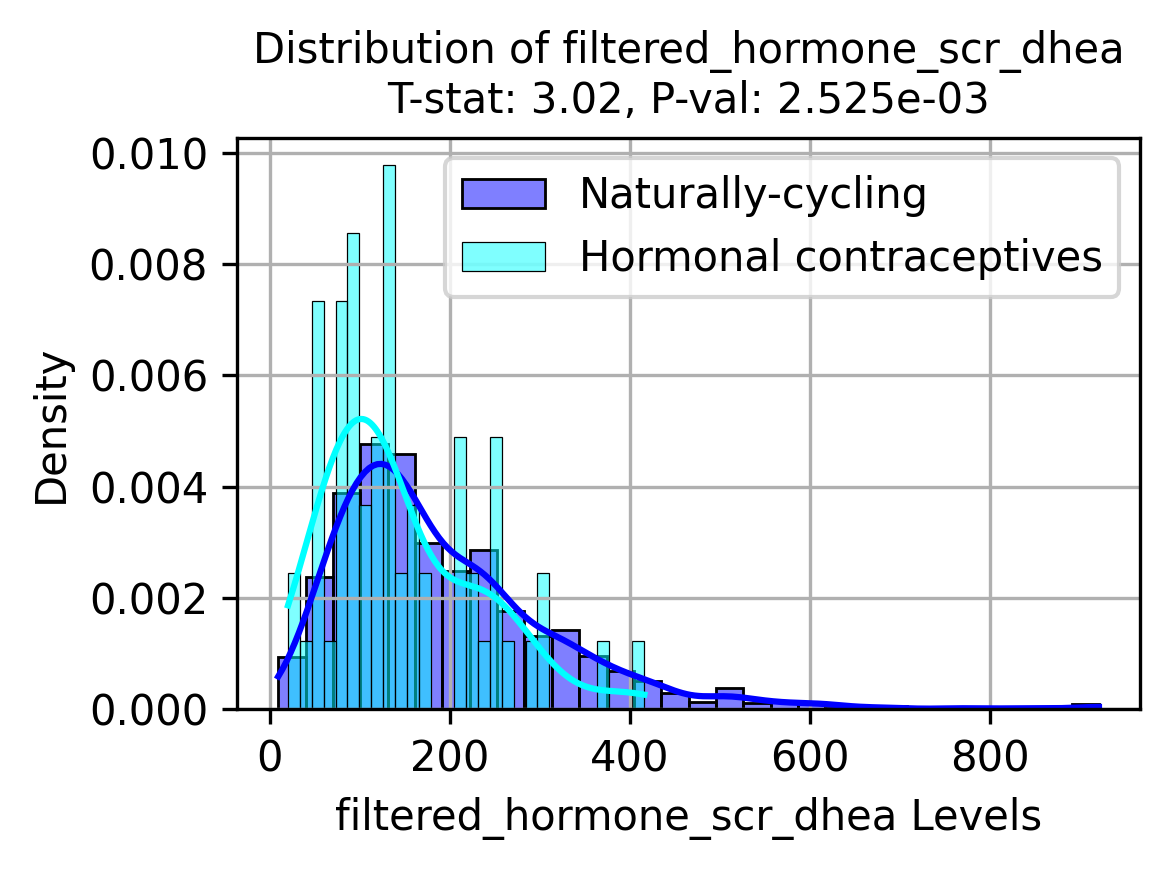

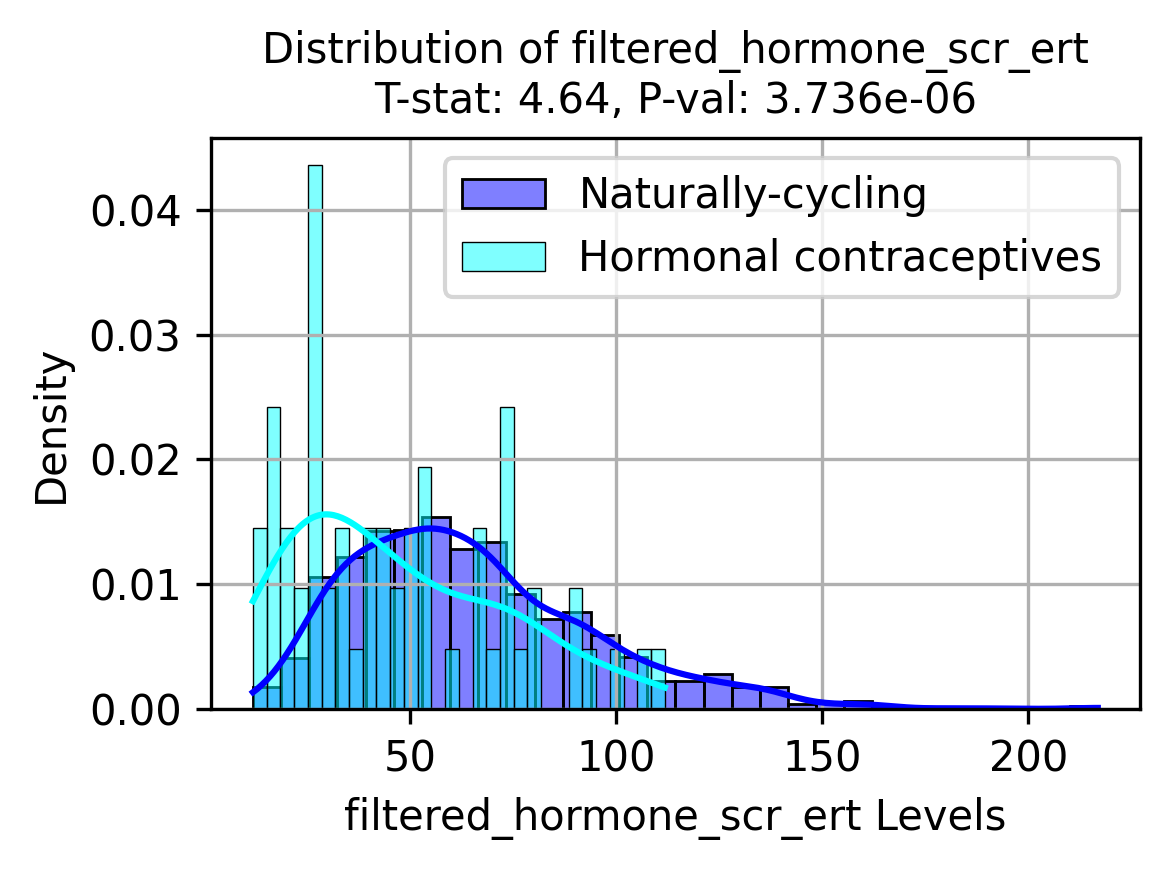

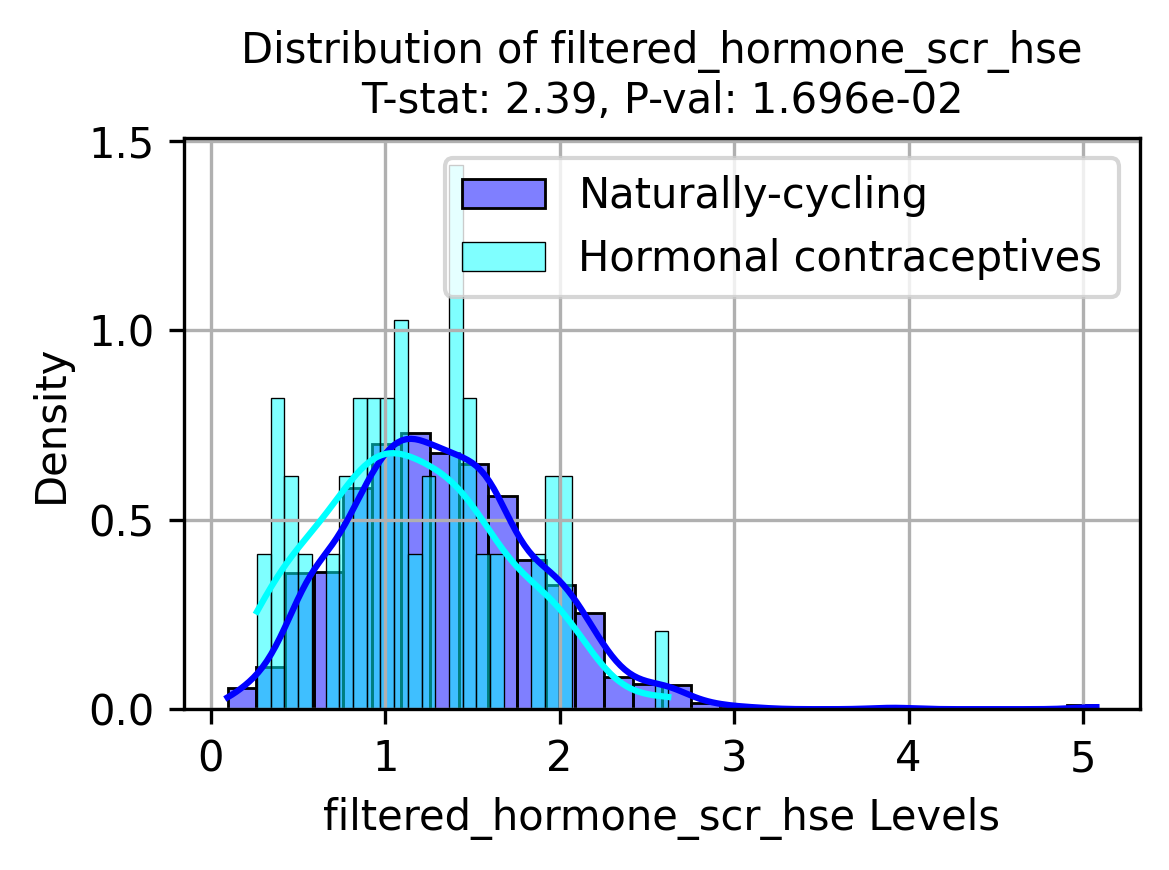

In [5]:
# visualize distributions of values

def plot_hormone_distributions(df, hormone):
    group_0 = df[df['menstrualcycle4_y'] == 0][hormone].dropna()
    group_1 = df[df['menstrualcycle4_y'] == 1][hormone].dropna()
    
    # Calculate t-test
    t_stat, p_val = stats.ttest_ind(group_0, group_1)
    
    # Plot the distributions
    plt.figure(figsize=(4, 3), dpi=300)
    sns.histplot(group_0, kde=True, color='blue', label='Naturally-cycling', stat="density", bins=30, alpha=0.5)
    sns.histplot(group_1, kde=True, color='cyan', label='Hormonal contraceptives', stat="density", bins=30, alpha=0.5)
    
    # Add labels and title
    plt.title(f'Distribution of {hormone}\nT-stat: {t_stat:.2f}, P-val: {p_val:.3e}', fontsize=10)
    plt.xlabel(f'{hormone} Levels')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot for each hormone
for hormone in hormones:
    plot_hormone_distributions(filtered_df, hormone)


In [22]:
# test for a difference in the slopes of correlations (ie, group-specific hormone-brain correlations)

# start by defining the functions
def fisher_z_transform(r):
    return np.arctanh(r)

def fisher_z_test(r1, n1, r2, n2):
    z1 = fisher_z_transform(r1)
    z2 = fisher_z_transform(r2)
    se = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    z_stat = (z1 - z2) / se
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))  # Two-tailed test
    return z_stat, p_value

# the data and variables
files = {
    'Area': 'area_correlations_output.csv',
    'Thickness': 'thk_correlations_output.csv',
    'Volume': 'Volume_correlations.csv'
}

r_values = ['r_dhea', 'r_ert', 'r_hse']

# Prepare a results list to store everything
all_results = []

# Loop over each file (area, thickness, volume)
for measure_type, file_path in files.items():
    
    # Load the data
    df = pd.read_csv(file_path)
    
    # Filter data for each group
    df_ocp_0 = df[df['OCP'] == 'OCP_0']
    df_ocp_1 = df[df['OCP'] == 'OCP_1']
    
    # Assuming sample sizes for both groups
    n1 = len(df_ocp_0)  # Sample size for OCP_0
    n2 = len(df_ocp_1)  # Sample size for OCP_1
    
    # Loop through each region and perform the test for each r-value
    for i, row in df_ocp_0.iterrows():
        region = row['label']
        
        # Find corresponding row in OCP_1 group
        row_ocp_1 = df_ocp_1[df_ocp_1['label'] == region]
        
        if not row_ocp_1.empty:
            for r_value in r_values:
                # Get r-values for both groups
                r_0 = row[r_value]
                r_1 = row_ocp_1[r_value].values[0]
                
                # Perform the Fisher Z-test
                z_stat, p_value = fisher_z_test(r_0, n1, r_1, n2)
                
                # Append the result
                all_results.append({
                    'Measurement': measure_type,
                    'Region': region,
                    'Hormone': r_value,
                    'z_stat': z_stat,
                    'p_value': p_value
                })

# Convert the results into a DataFrame and display
results_df = pd.DataFrame(all_results)
print(results_df)

    Measurement                       Region Hormone    z_stat   p_value
0          Area                  lh_bankssts  r_dhea -0.870164  0.384211
1          Area                  lh_bankssts   r_ert -0.116947  0.906902
2          Area                  lh_bankssts   r_hse -0.411609  0.680626
3          Area   lh_caudalanteriorcingulate  r_dhea  1.256173  0.209053
4          Area   lh_caudalanteriorcingulate   r_ert  0.545800  0.585203
5          Area   lh_caudalanteriorcingulate   r_hse  0.767815  0.442597
6          Area       lh_caudalmiddlefrontal  r_dhea -1.057328  0.290362
7          Area       lh_caudalmiddlefrontal   r_ert -1.266088  0.205482
8          Area       lh_caudalmiddlefrontal   r_hse -0.380971  0.703224
9          Area                    lh_cuneus  r_dhea -0.370537  0.710983
10         Area                    lh_cuneus   r_ert -0.700903  0.483363
11         Area                    lh_cuneus   r_hse  0.521383  0.602100
12         Area                lh_entorhinal  r_dhe